# Make plots of layer orientation

Requires master_orientation.py has already been run

## Import packages

In [43]:
# general
import numpy as np
import pandas as pd
import math
from scipy import stats

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# math
from statsmodels.stats.weightstats import DescrStatsW

# my functions/classes
import sys
sys.path.append("../core_scripts/")
from ECMclass import ECM


## Set Filepaths

In [44]:
path_to_angles = '../../data/angles/'
path_to_figures = '../../../figures/'

## Load Angle Data

Requires that master_orientation.py has already been run

In [45]:
alhic2201 = pd.read_pickle(path_to_angles+'alhic2201_angles.df')

## Adjust Aparent Dip for geometry

All aparent dip is calculated in the same reference frame. However, we need to flip one of the two faces for both cores to achieve our definition of a positive dip as sloping down from the center of the core. This means flipping 't' on ALHIC2201 and 'l' on ALHIC2302

In [46]:
# multiply all angles in 'AC-t-angles' by -1 in alhic2302
for index,row in alhic2201.iterrows():
    alhic2201.at[index,'AC-t-angles'] = list(map(lambda x: x * -1, row['AC-t-angles']))


# Load ECM data

In [47]:
# smoothing window, mm
window = 10

# paths
path_to_data = '../../data/'
metadata_file = 'metadata.csv'

# make colormap
my_cmap = matplotlib.colormaps['Spectral']

#%%
# Read in metadata and import data

meta = pd.read_csv(path_to_data+metadata_file)

# import each script as an ECM class item
data = []
cores = []
sections = []
faces = []
ACorDCs = []
for index,row in meta.iterrows():
    
    core = row['core']
    ACorDC = row['ACorDC']
    section = row['section']
    
    # filter for ALHIC2302 shallow ice
    if core == 'alhic2201' and ACorDC == 'AC' and section != '10_1':
        
        # pull out metadata
        face = row['face']
        
        print("Reading "+core+", section "+section+'-'+face+'-'+ACorDC)
        # read in data
        data_item = ECM(core,section,face,ACorDC)
        # remove last 10mm from either end
        data_item.rem_ends(10)
        # normalize outside tracks
        data_item.norm_outside()
        # apply smoothing (at specified window)
        data_item.smooth(window)
        #add to list
        data.append(data_item)
        cores.append(core)
        sections.append(section)
        faces.append(face)
        ACorDCs.append(ACorDC)

# make sections into set (remove duplicates)
sec = set(sections)

Reading alhic2201, section 11_1-r-AC
Reading alhic2201, section 11_1-t-AC
Reading alhic2201, section 12_1-r-AC
Reading alhic2201, section 12_1-t-AC
Reading alhic2201, section 13_1-r-AC
Reading alhic2201, section 13_1-t-AC
Reading alhic2201, section 14_1-r-AC
Reading alhic2201, section 14_1-t-AC
Reading alhic2201, section 15_1-r-AC
Reading alhic2201, section 15_1-t-AC
Reading alhic2201, section 16_1-r-AC
Reading alhic2201, section 16_1-t-AC
Reading alhic2201, section 18_1-r-AC
Reading alhic2201, section 18_1-t-AC
Reading alhic2201, section 19_1-r-AC
Reading alhic2201, section 19_1-t-AC
Reading alhic2201, section 1_1-r-AC
Reading alhic2201, section 1_1-t-AC
Reading alhic2201, section 20_1-r-AC
Reading alhic2201, section 20_1-t-AC
Reading alhic2201, section 21_2-r-AC
Reading alhic2201, section 21_2-t-AC
Reading alhic2201, section 22_1-r-AC
Reading alhic2201, section 22_1-t-AC
Reading alhic2201, section 23_1-r-AC
Reading alhic2201, section 23_1-t-AC
Reading alhic2201, section 24_1-r-AC
Rea

In [48]:
# define function to find unique elements in list
def unique(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    
    return(unique_list)

In [49]:
def plotquarter(y_vec,ycor,d,meas,button,axs,rescale):

    res = 0.002
    
    width = y_vec[1] - y_vec[0]
    
    for y in y_vec:
        
        
        idx = ycor==y
        
        tmeas = meas[idx]
        tbut = button[idx]
        tycor = ycor[idx]
        td = d[idx]

            # downsample ECM to save plotting time (as needed)
        if res != 0:
            int_lo = round(min(td),2)
            int_hi = round(max(td),2)
            depth_interp = np.linspace(int_lo,int_hi,int((int_hi-int_lo)/res)+1)
            meas_interp = np.interp(depth_interp,np.flip(td),np.flip(tmeas))
            but_interp = np.interp(depth_interp,np.flip(td),np.flip(tbut))
            td = depth_interp
            tmeas = meas_interp
            tbut = np.round(but_interp)
        
        for i in range(len(tmeas)-1):
            
            if tbut[i] == 0:
                
                axs.add_patch(Rectangle((y-(width-0.2)/2,td[i]),(width-0.2),td[i+1]-td[i],facecolor=my_cmap(rescale(tmeas[i]))))
            else:
                axs.add_patch(Rectangle((y-(width-0.2)/2,td[i]),(width-0.2),td[i+1]-td[i],facecolor='k'))
            
    return()

# Set up vector stuff

In [50]:
def sph_to_cart(delta_deg, alpha_deg):
    """Convert (dip, azimuth) in degrees to unit vector [x,y,z]."""
    d = np.deg2rad(delta_deg)
    a = np.deg2rad(alpha_deg)
    return np.column_stack([np.cos(d)*np.sin(a), np.cos(d)*np.cos(a), np.sin(d)])


In [51]:
def weighted_spherical_median(vectors, weights, tol=1e-6, max_iter=1000):

    """Weighted Weiszfeld algorithm on the sphere."""
    m = np.average(vectors, axis=0, weights=weights)
    m /= np.linalg.norm(m)

    for _ in range(max_iter):

        dots = np.clip(vectors.dot(m), -1, 1)
        
        angles = np.arccos(dots)
        if np.any(angles < tol):
            return vectors[np.argmin(angles)]
        w_ang = weights / angles
        m_new = (w_ang[:, None] * vectors).sum(axis=0)
        m_new /= np.linalg.norm(m_new)
        if np.linalg.norm(m_new - m) < tol:
            m = m_new
            break
        m = m_new

    return m

def weighted_spherical_mean(vectors, weights):
    """Weighted spherical mean."""
    m = np.average(vectors, axis=0, weights=weights)
    m /= np.linalg.norm(m)

    return m

## Calculate True Angle Orientations

In [52]:
df = alhic2201
face = 'r'

Processing section:  11_1
section: 11_1


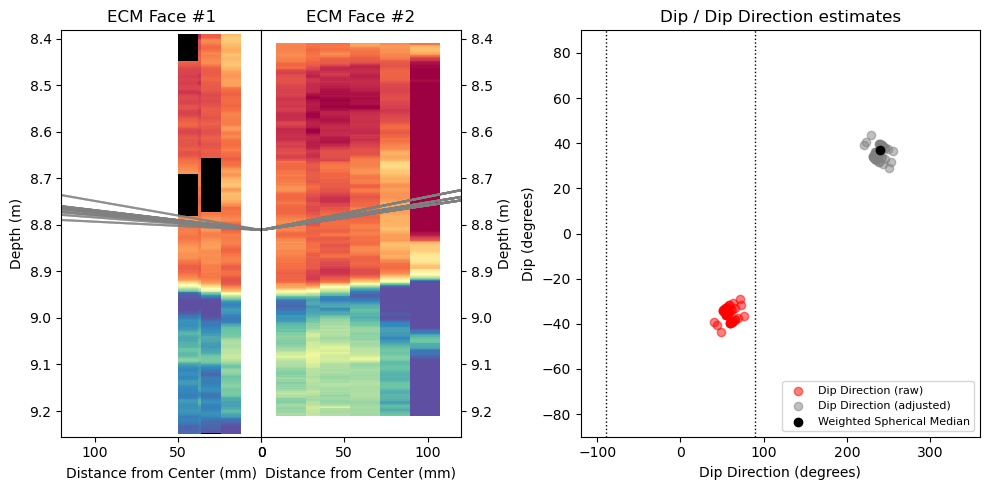

Processing section:  12_1
section: 12_1


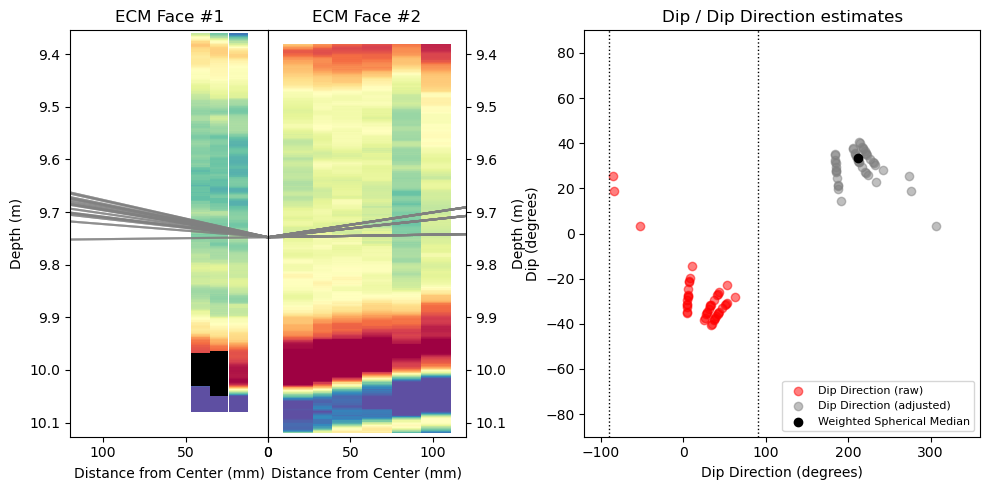

Processing section:  13_1
section: 13_1


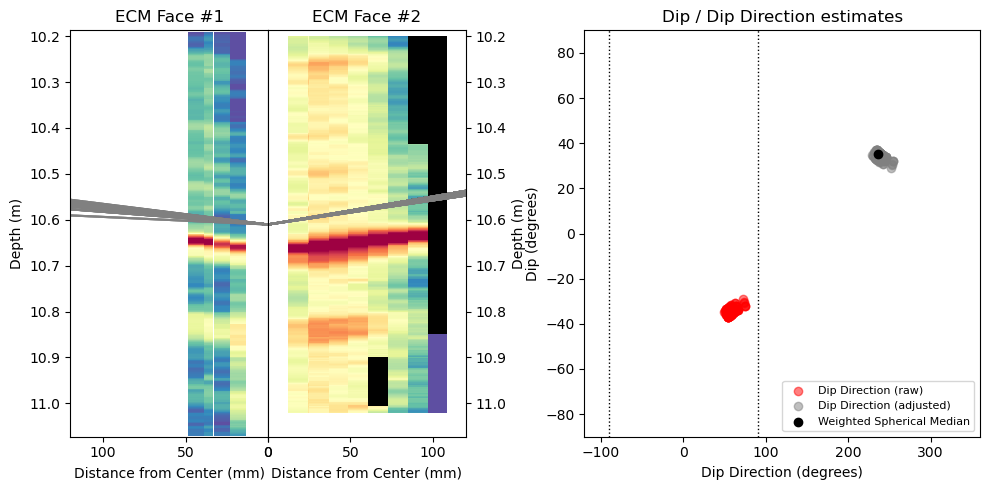

Processing section:  14_1
section: 14_1


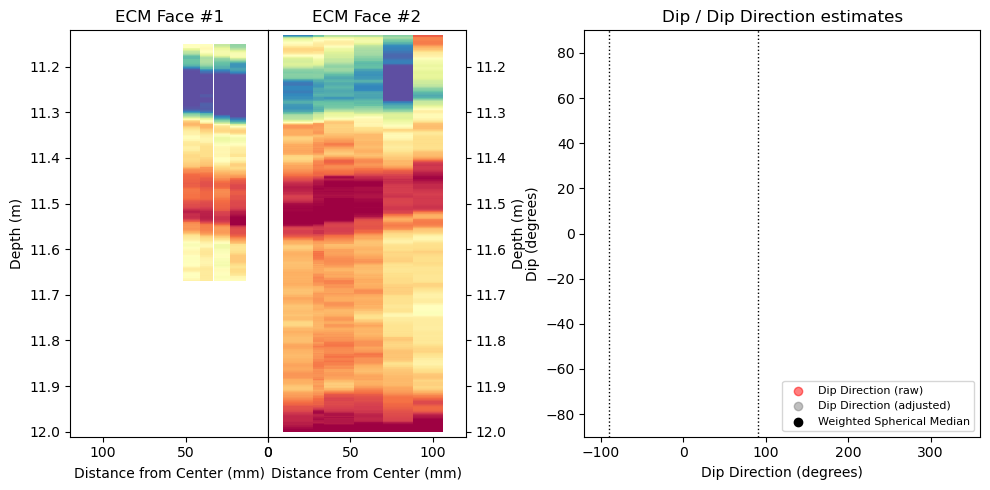

Processing section:  15_1
section: 15_1


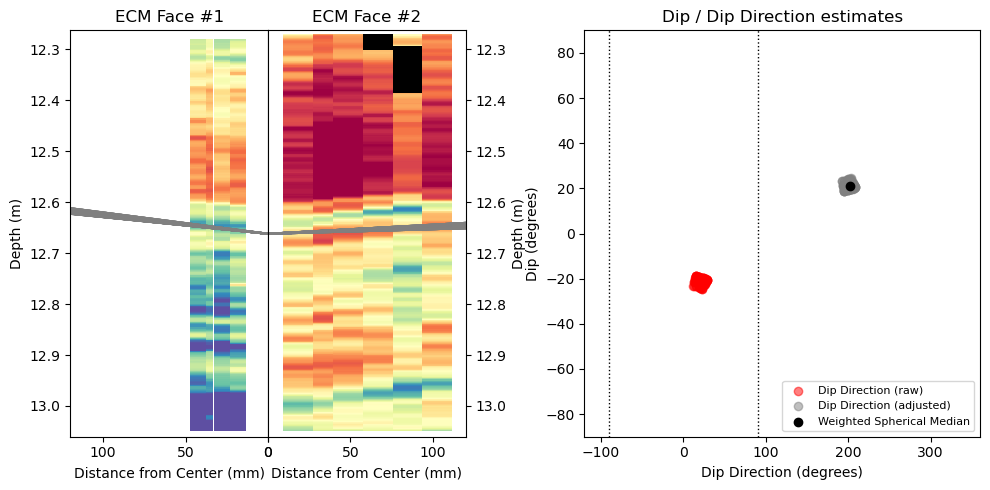

Processing section:  16_1
section: 16_1


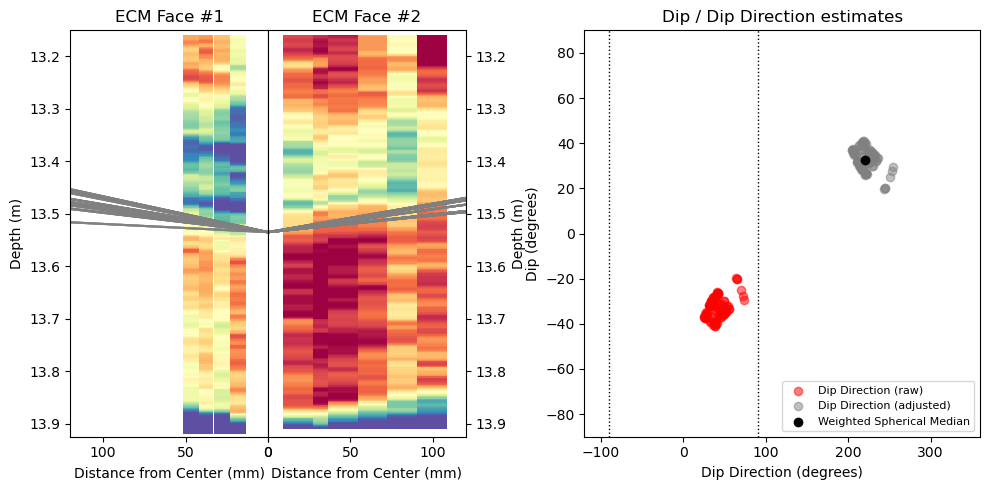

Processing section:  18_1
section: 18_1


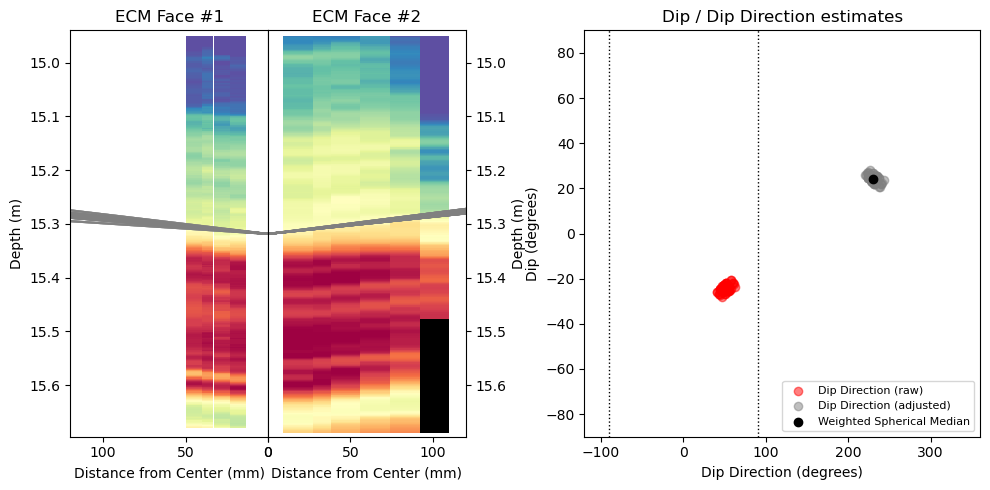

Processing section:  19_1
section: 19_1


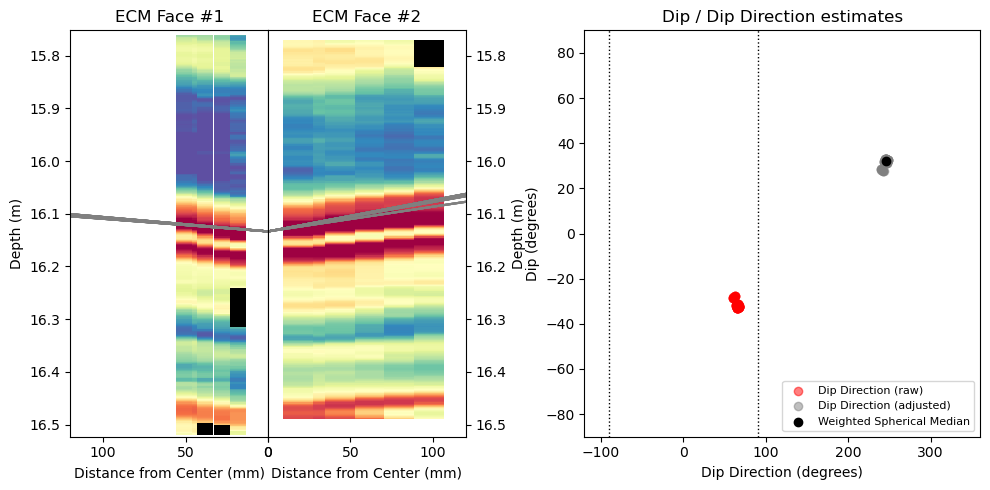

Processing section:  1_1
section: 1_1


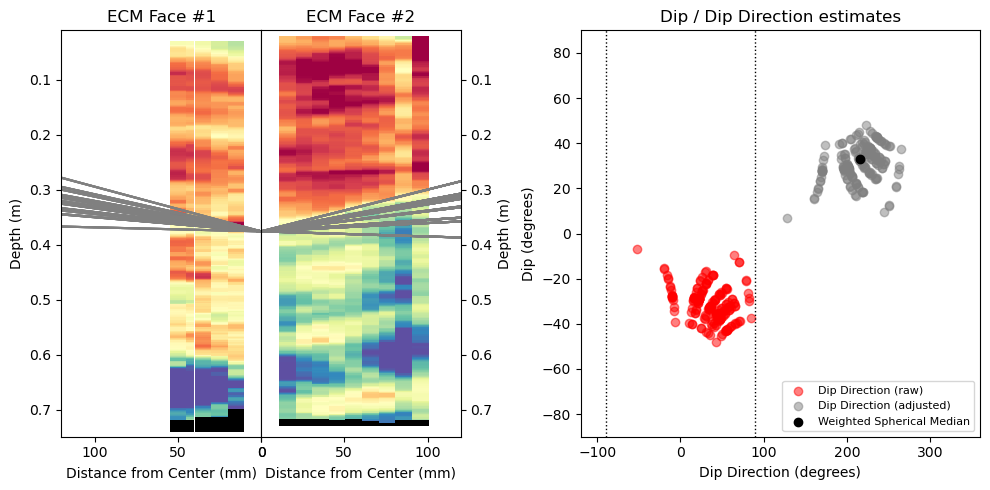

Processing section:  20_1
section: 20_1


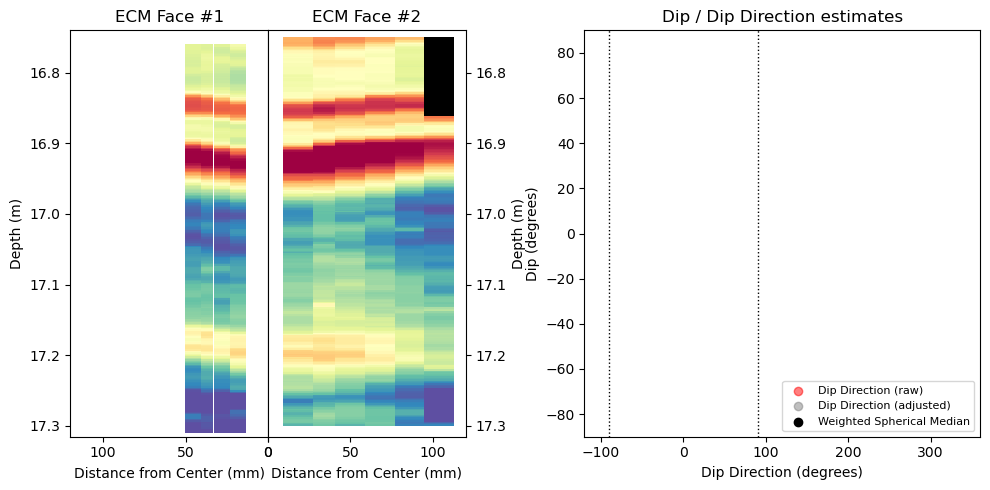

Processing section:  21_2
section: 21_2


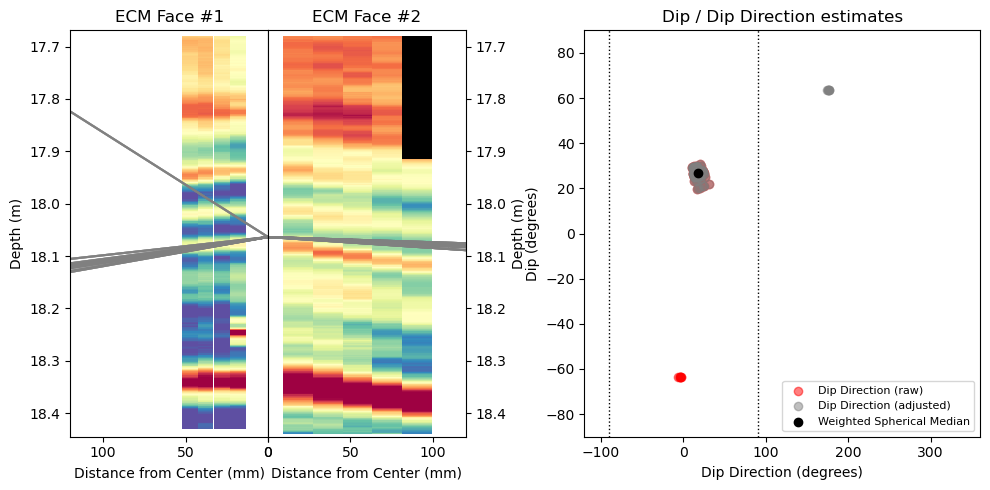

Processing section:  22_1
section: 22_1


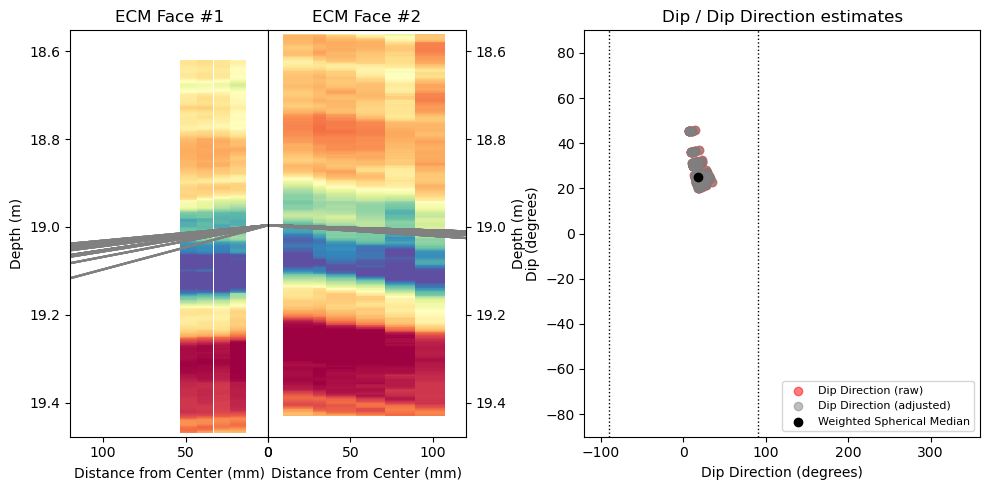

Processing section:  23_1
section: 23_1


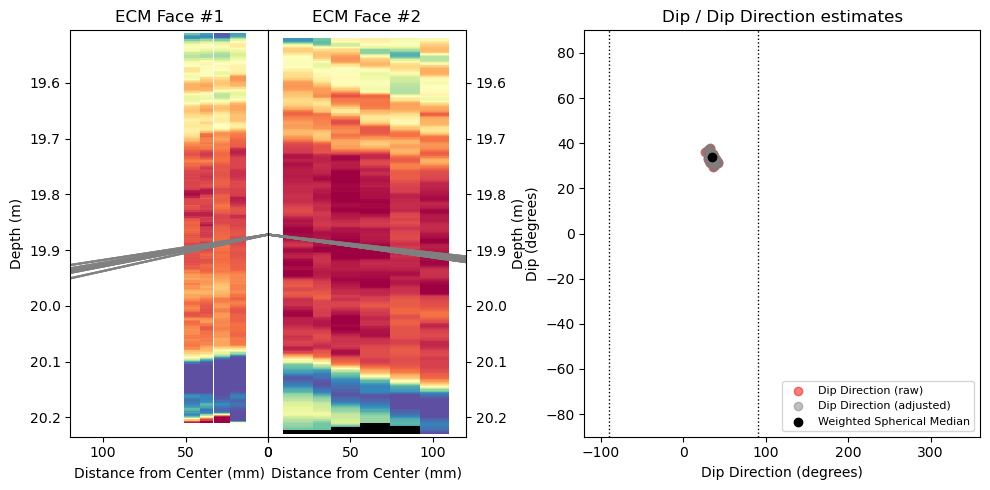

Processing section:  24_1
section: 24_1


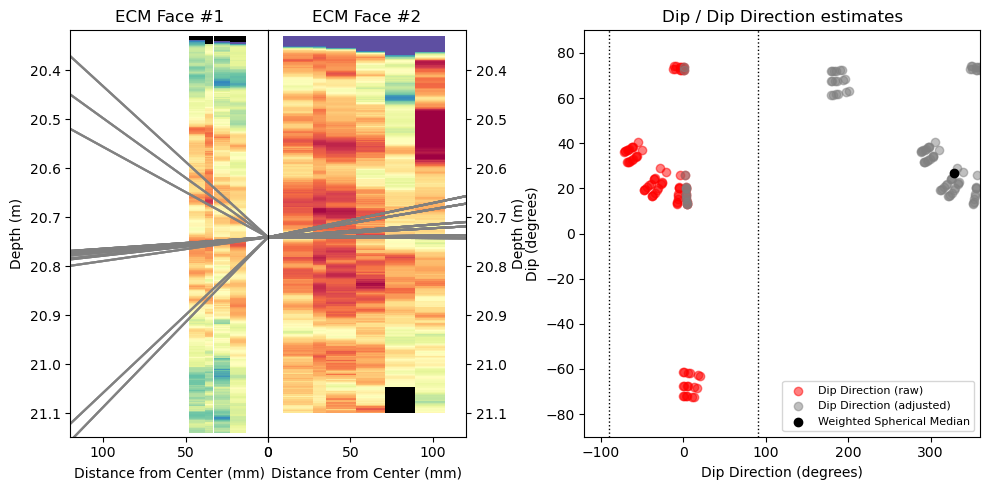

Processing section:  25_1
section: 25_1


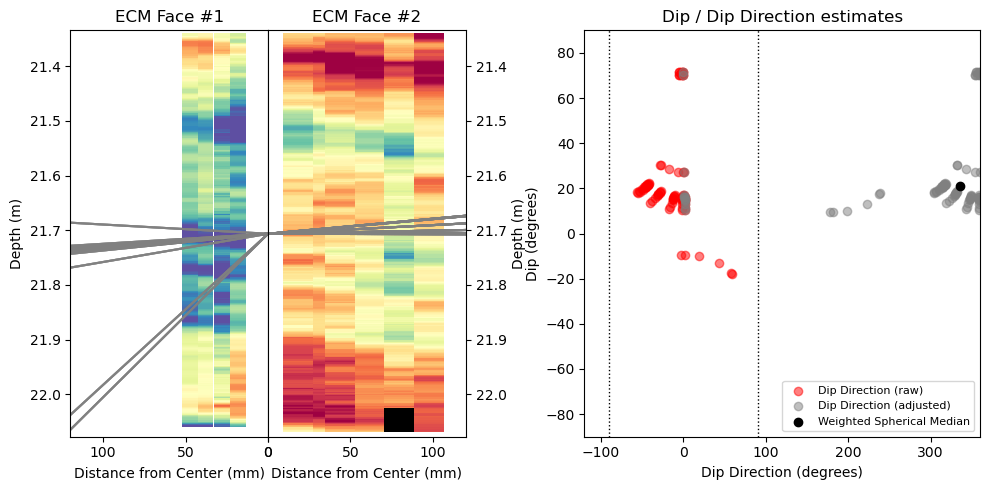

Processing section:  26_1
section: 26_1


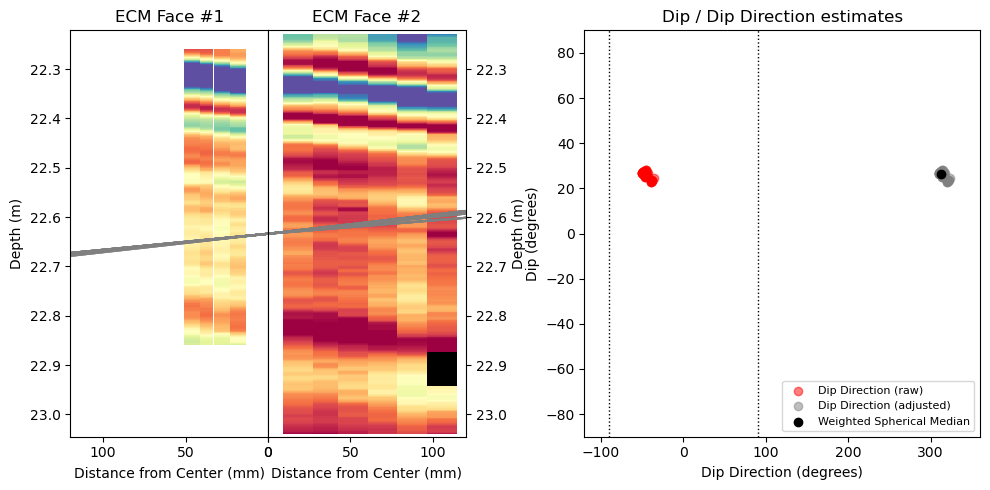

Processing section:  2_1
section: 2_1


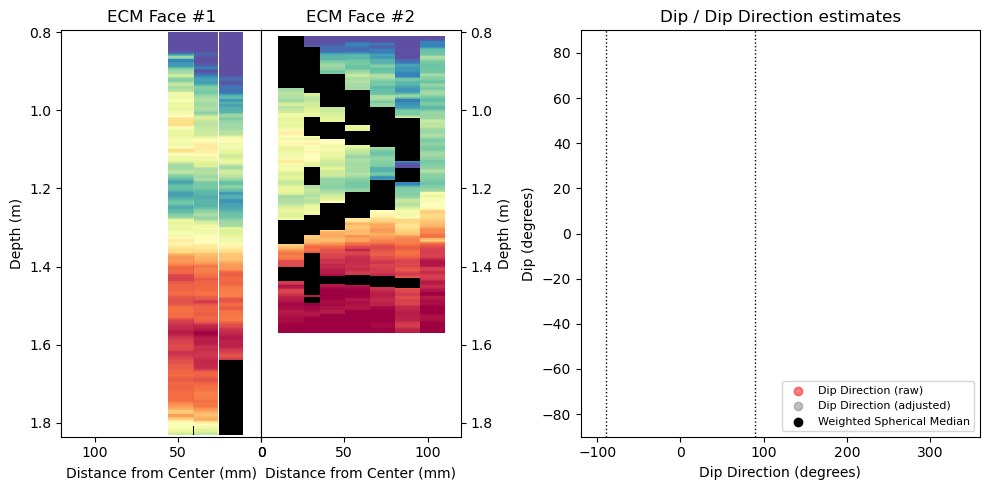

Processing section:  4_2
section: 4_2


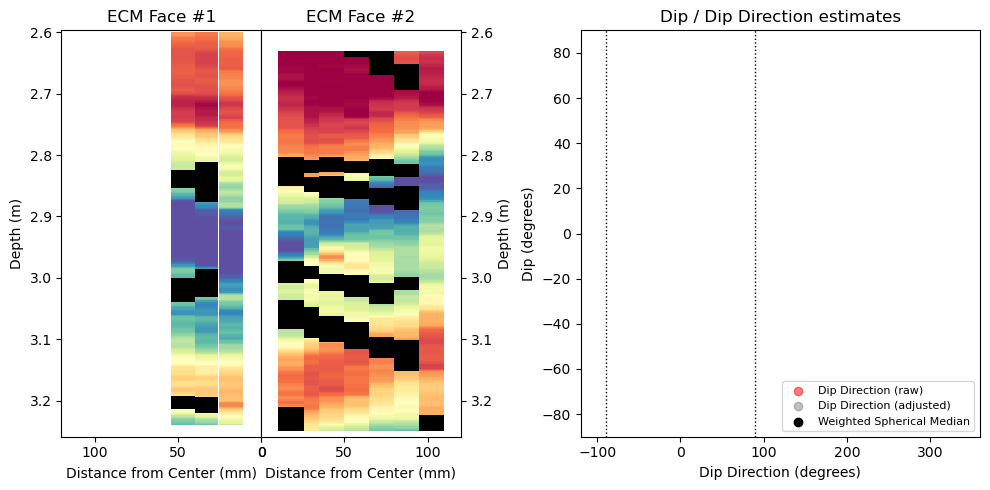

Processing section:  5_1
section: 5_1


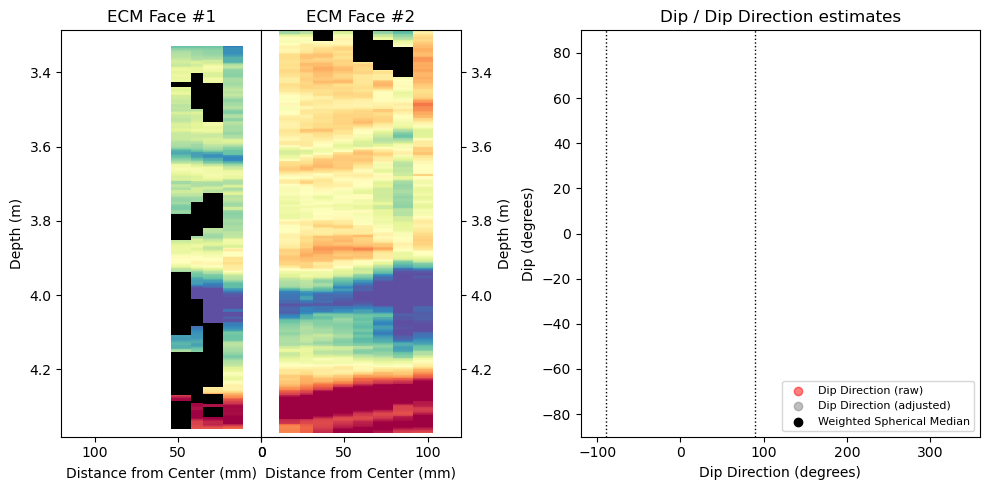

Processing section:  7_1
section: 7_1


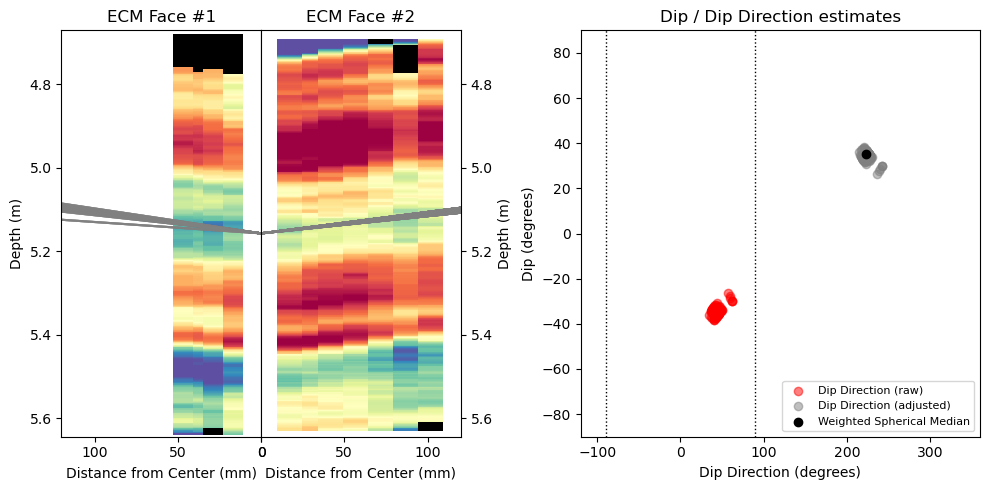

Processing section:  8_1
section: 8_1


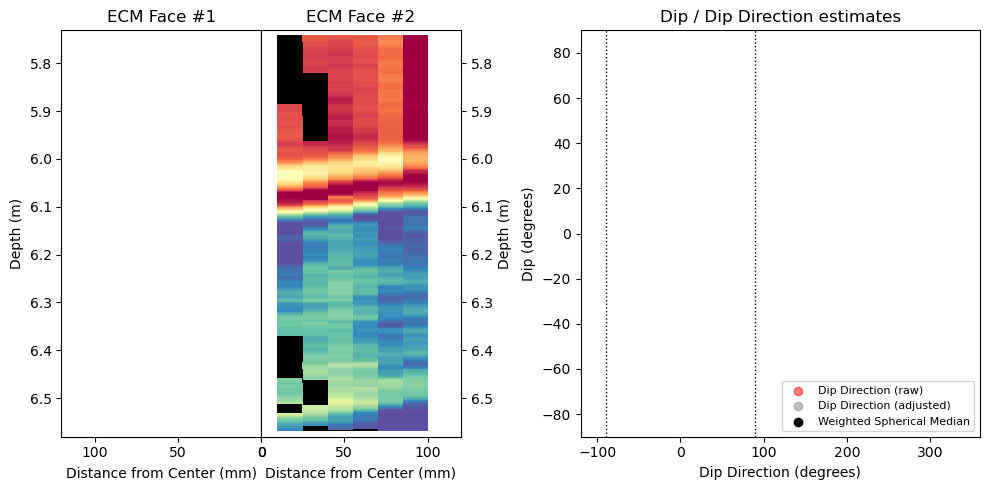

Processing section:  9_1
section: 9_1


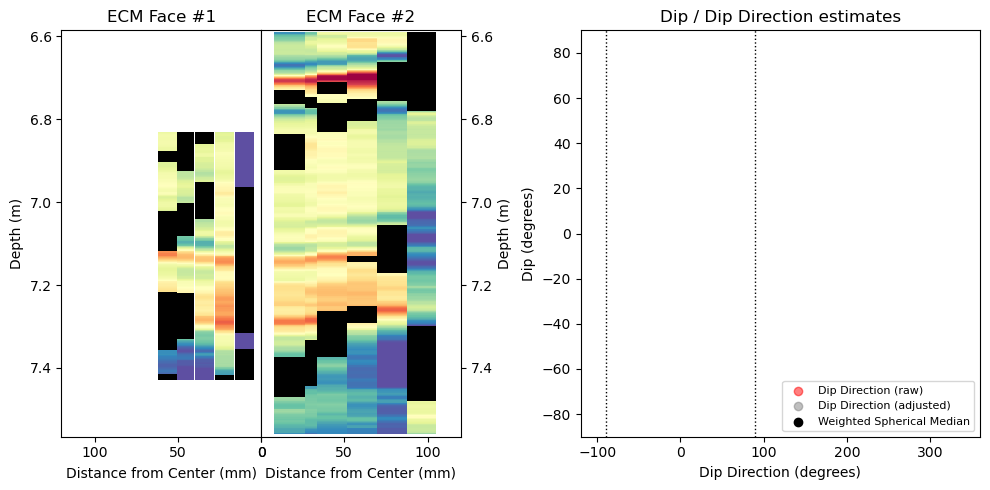

In [ ]:

for sec in df['section']:

    if sec not in ['10_1']:

        print("Processing section: ", sec)

        # set row where section is section
        row = df[df['section'] == sec].iloc[0]

        # pull out values from the side (first check there are three)
        if row['AC-'+face+'-angles'] != None and len(row['AC-'+face+'-angles']) > 2:
            add_nan = False
            side_angle = np.array(row['AC-'+face+'-angles']) * np.pi/180
            side_score = np.array(row['AC-'+face+'-scores'])
            side_length = np.array(row['AC-'+face+'-length'])
        else:
            add_nan = True

        # pull out values from the top
        if row['AC-t-angles'] != None and len(row['AC-t-angles']) > 2:
            top_angle = np.array(row['AC-t-angles']) * np.pi/180
            top_score = np.array(row['AC-t-scores'])
            top_length = np.array(row['AC-t-length'])
        else:
            add_nan = True


        # set true angle to nan if we don't have enough data
        if add_nan:
            dip_score_ind = [np.nan]
            dip_dir_ind = [np.nan]
            dip_ind = [np.nan]
            dip_dir_raw = [np.nan]
            dip_raw = [np.nan]
            d1s = [np.nan]
            d2s = [np.nan]
            vectors = [np.nan]
            weights = [np.nan]
            dip_median = np.nan
            dd_median = np.nan

        # else, calculate dip and save to list
        else:

            # assign delta 1 and delta 2
            d1 = top_angle
            d2 = side_angle
            
            d1_score = top_score * top_length
            d2_score = side_score * side_length

            d1_length = top_length
            d2_length = side_length
                
            # make empty lists
            dip_score_ind = []
            dip_dir_ind = []
            dip_ind = []
            dip_dir_raw = []
            dip_raw = []
            d1s = []
            d2s = []
            vectors = []
            weights = []

            for i in range(len(d2)):
                for j in range(len(d1)):

                    # calculate dip score
                    ds = d1_score[j] * d2_score[i]
                    dip_score_ind.append(ds)

                    # calculate dip direction
                    dd = np.arctan(np.tan(d2[i])/np.tan(d1[j])) 
                    d1s.append(d1[j])
                    d2s.append(d2[i])

                    # calculate true dip
                    d = np.arctan(np.tan(d1[j])/np.cos(dd))

                    # store values
                    dip_dir_raw.append(dd* 180 / np.pi)
                    dip_raw.append(d* 180 / np.pi)

                    # # now deal with cases where the dip is negative
                    if d < 0:
                        d = d*-1
                        dd = dd + np.pi
                        # dd = dd * -1

                    # create a vector for each plane
                    vector = sph_to_cart(np.rad2deg(d), np.rad2deg(dd))
                    vectors.append(vector[0])
                    weights.append(ds)

                    if dd < 0:
                        dd = dd + 2*np.pi

                    if dd > 2*np.pi:
                        dd = dd - 2*np.pi

                    # store values
                    dip_dir_ind.append(dd* 180 / np.pi)
                    dip_ind.append(d* 180 / np.pi)

            # convert list of 3D vectors to numpy array
            vectors = np.array(vectors)
            weights = np.array(weights)
            m = weighted_spherical_median(vectors,weights)
            dip_median = np.rad2deg(np.arcsin(m[2])) #np.arctan2(np.linalg.norm(m[:2]), m[2])#np.rad2deg(np.arcsin(m[2]))#
            dd_median = np.rad2deg(np.arctan2(m[0], m[1]))

            # convert list of vectors to list of dip and dip direction
            dip_dir_vec = np.rad2deg(np.arctan2(vectors[:, 0], vectors[:, 1]))
            dip_vec = np.rad2deg(np.arcsin(vectors[:, 2]))

            if dip_median < 0:
                dip_median = dip_median * -1
                dd_median = dd_median + 180
            if dd_median < 0:
                dd_median += 360
            if dd_median>360:
                dd_median -= 360

        
        # switch to plotting
        depth = row['depth']
        section = row['section']
        print('section:', section)

        # set up the figure
        fig = plt.figure(figsize=(10, 5))

        # Define the grid layout
        gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, .6, 2], wspace=0)

        # Create subplots
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        ax3 = fig.add_subplot(gs[0, 3])

        ####################################################################

        # PLOT ECM

    # set data to empty
        AC_t = None
        AC_r = None
        #loop through data 
        for d in data:
            
            # find faces
            if d.core=='alhic2201':
                if d.section==sec:
                    if d.ACorDC == 'AC':
                        if d.face == 't':
                            AC_t = d
                        if d.face == 'r':
                            AC_r = d                    

        # find depth max and minimum
        minvec = []
        maxvec = []
        AC_all = []
        for data_face in [AC_t,AC_r]:
            if data_face != None and data_face.ACorDC == 'AC':
                minvec.append(min(data_face.depth))
                maxvec.append(max(data_face.depth))
                AC_all.extend(data_face.meas)
        ACpltmin = np.percentile(AC_all,5)
        ACpltmax = np.percentile(AC_all,95)
        ACrescale = lambda k: (k-ACpltmin) /  (ACpltmax-ACpltmin)
        dmin = min(minvec)
        dmax = max(maxvec)
        
        
        ax1.set_ylim(dmax, dmin)
        ax2.set_ylim(dmax, dmin)
            

        for a,data_face in zip([ax1,ax2],[AC_r,AC_t]):
            
            if data_face != None:
                if data_face.face == 'r':
                    yall = data_face.y_s - data_face.y_left
                    yvec = data_face.y_vec - data_face.y_left
                else:
                    yall = data_face.y_right - data_face.y_s
                    yvec = data_face.y_right - data_face.y_vec
            
                # plot data
                plotquarter(yvec,
                            yall,
                            data_face.depth_s,
                            data_face.meas_s,
                            data_face.button_s,
                            a,
                            ACrescale)
            

        ####################################################################


        # titles for the subplots
        ax1.set_title("ECM Face #1")
        ax2.set_title("ECM Face #2")
        ax3.set_title("Dip / Dip Direction estimates")

        # set the x and y limits for each subplot
        ax3.set_xlim(-120, 360)
        ax3.set_ylim(-90, 90)
        ax1.set_xlim(120, 0)
        ax2.set_xlim(0,120)

        # add a vertical dashed line at 90 degrees and -90 degrees
        ax3.axvline(x=90, color='k', linestyle=':', linewidth=1)
        ax3.axvline(x=-90, color='k', linestyle=':', linewidth=1)


        # set axis labels
        ax3.set_xlabel("Dip Direction (degrees)")
        ax3.set_ylabel("Dip (degrees)")
        ax1.set_xlabel("Distance from Center (mm)")
        ax2.set_xlabel("Distance from Center (mm)")
        ax1.set_ylabel("Depth (m)")
        ax2.set_ylabel("Depth (m)")

        # move axis 2 labels to the right
        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position("right")

        # plot the data
        #ax3.plot(dip_dir_1, dip_1, 'ro', label='Dip 1')
        #ax3.plot(dip_dir_2, dip_2, 'bo', label='Dip 2')
        ax3.scatter(dip_dir_raw, dip_raw,  color='red', alpha=0.5, label='Dip Direction (raw)')
        ax3.scatter(dip_dir_ind, dip_ind,color='grey', alpha=0.5, label='Dip Direction (adjusted)')
        #ax3.scatter(dip_dir_vec, dip_vec,color='blue', alpha=0.5, label='Dip Direction (vector)')

        ax3.scatter(dd_median, dip_median, color='black', label='Weighted Spherical Median')

        ax3.legend(loc='lower right', fontsize=8)

        # plot the side angles
        for i in range(len(d2s)):
            ax1.plot([120,0], [depth + 120 * np.tan(d1s[i])/1000, depth], color='grey', alpha=0.5)
        for i in range(len(d1s)):
            ax2.plot([0,120], [depth,depth + 120 * np.tan(d2s[i])/1000], color='grey', alpha=0.5)

        # Show the figure
        plt.tight_layout()
        plt.show()

        # save the figure
        fig.savefig(path_to_figures+'dipflip/ALHIC2302'+sec+'_'+face+'_ECM_dip.png', dpi=300, bbox_inches='tight')

In [54]:
AC_t